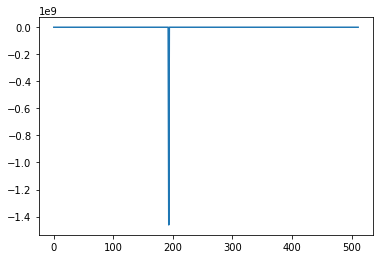

In [2]:
# Marc Mekhanik 260762445 Compressed Sensing Experiment

# Imports and standard helper functions
import numpy as np
import math
import cvxpy as cp
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import random

# We will recover a 1024-length signal w/ a Gaussian measurement ensemble

def generate_sparse_vector(size,nonzeros):
    # this will create a vector of length size
    # with nonzeros number of random nonzero entries
    # We will obtain this vector in a similar manner to how Tao et al did it.
    # which is assigning 50 1s or zeros randomly from a uniform distribution.
    if nonzeros > size:
        print("Cannot have more nonzeros than entries")
        return
    x = np.zeros(size)
    # now to choose a random collection of indices
    #to do this I will first create an array of indices.
    all_indices = np.arange(0,size)
    indices = np.random.choice(all_indices,50,replace=False)
    # false is so we sample w/o replacement
    # this is the only thing I have to change
    for i in indices:
        # coin flip
        value = np.random.binomial(1,0.5)
        if value == 1:
            x[i] = 1
        else:
            x[i] = -1
#     x[indices] = np.random.rand(nonzeros)
    return x

# this section is to recover compressible vectors, but isn't quite working yet.
def sequence(t):
    return 5.819*(t**(-1.05))

def generate_compressible_vector():
    # this will be made to measure. 
    # the sequence is x(t) = 5.819*t^(10/9)
    vectorized_sequence = np.vectorize(sequence)
    
    inputs = np.linspace(1e-8,512,512)
    data = vectorized_sequence(inputs)
    
    # shuffle operates in-place
    np.random.shuffle(data)
    #ok now more.
    data = [each*random.choice([-1,1]) for each in data]
    return data
x = generate_compressible_vector()
plt.plot(x)
# for some reason this is going to zero too fast, definitely something to fix.

We will solve the $\ell_1$-minimization problem of basis pursuit. 
$$ \min ||x||_1 \text{ subject to } ||Ax - y||_2 \leq \epsilon $$
which we can cast as a convex program, specifically a second order cone problem (SOCP). 
To solve this problem we will use the convex optimization solving package CVXPY.

In general, a SOCP takes the form
$$
\begin{align}
    \text{minimize } & f^T(x)\\ 
    \text{ subject to } & ||Ax_i - b_i||_2 \leq c_i^Tx + d_i, \, i = 1,\dots,m \\
    & Fx = g
\end{align}
$$
We have 1 constraint, $||Ax - y||_2 \leq \epsilon$, our objective function $f$ has form $\sum_{i = 1}^n |x_i|$
so in the standard form of the SOCP, we have $m=1$, $c_1 = 0, d_i = \epsilon$.

300


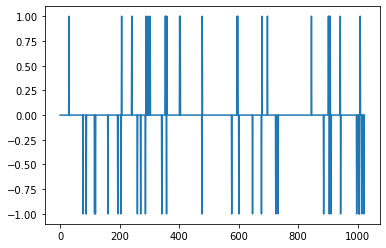

In [4]:
# sandbox
#let's solve a least squares problem as a sanity check

In [5]:
# How to construct a Gaussian measurement ensemble
# I will replicate the experiment of Tao et al, and create a 300 x 1024 Gaussian measurement ensemble
# aka a 300 by 1024 matrix A s.t. every entry in A is chosen from a normal distribution
A = np.random.randn(300,1024)
x = generate_sparse_vector(1024,50)
y = A @ x
#now to corrupt our measurement vector y with Gaussian noise
y_noisy = y + 0.05*np.random.randn(len(y))
is_y_noisy = not np.allclose(y_noisy,y)
print("y_noisy is noisy:", is_y_noisy )
 

y_noisy is noisy: True


In [5]:
#This cell is for implementing the CVXPY solver
# We need a term for our error, otherwise impossible to use solver.
# by Tao et al, eps = sigma^2(n + 2sqrt(2n))
# Q: what's n?? the amount of measurements, so in my case 300
def recovery_process(noise,sparse=True):
    # we're going to recover a signal
    #choose your fighter
    if sparse:
        signal_to_recover = generate_sparse_vector(1024,50)
    else:
        signal_to_recover = generate_compressible_vector()
    # using the cvxpy socp solver
    # at various noise levels
    # and performing to recovery 10 times per noise level
    # to get an average error
    # for each recovery, we will use the same 300 x 1024 Gaussian Ensemble
    A = noise * np.random.randn(300,1024)
    # take measurements
    y = A @ signal_to_recover
    #corrupt measurements with noise
    y_noisy = y + noise*np.random.randn(len(y))
    #set noise to solve
    eps = math.sqrt(noise*(300+ 2*math.sqrt(2*300)))
    #solve baybee
    x = cp.Variable(1024)
    #we use cp.SOC(t,x) to get ||x||_2 < t
    soc_constraints = [cp.SOC(eps, A @ x - y_noisy)]
    prob = cp.Problem(cp.Minimize(cp.norm(x,1)),soc_constraints)
    prob.solve(solver=cp.ECOS, max_iters=200)
    return (x.value,signal_to_recover)
    
    
# ok let's give this a spin
# (recovered_vector,x) = recovery_process(0.9)
# f, (ax1,ax2) = plt.subplots(1,2,sharey=True)
# ax1.plot(x)
# ax1.set_title("signal")
# ax2.plot(recovered_vector)
# ax2.set_title("Recovered signal")
# plt.show()
# error = np.linalg.norm((x - recovered_vector),2)
# print("error is ", error)


# (recovered_y,y) = recovery_process(0.5,sparse = False)
# f, (ax1,ax2) = plt.subplots(1,2,sharey=True)
# ax1.plot(y)
# ax1.set_title("signal")
# ax2.plot(recovered_vector)
# ax2.set_title("Recovered signal")
# plt.show()
# error = np.linalg.norm((y - recovered_vector),2)
# print("error is ", error)

In [6]:
#ok
# so in a very odd turn of events this performs better in noisier systems
x = generate_sparse_vector(1024,50)

def avg_10_recoveries(noise):
    #we're gonna perform the recovery 10 times at a noise level
    # and get the average error and eps.
    # noise_levels should be an array
    errors = np.zeros(10)
    for i in range(0,10):
        #perform recovery
        (recovered_vector,signal) = recovery_process(noise)
        errors[i] = np.linalg.norm((signal - recovered_vector),2)
    avg_error = np.average(errors)
    return avg_error

# test = avg_10_recoveries(0.25)
#print("average error with sigma^2 = 0.25 is", test)
noise_eps = np.array([[0.25,0.3,0.4,0.5,0.9],[0,0,0,0,0],[0,0,0,0,0]])
for i in range(0,5):
    #second row is column for epsilon
    noise_eps[1,i] = math.sqrt(noise_eps[0,i]*(300+ 2*math.sqrt(2*300)))

#whew now for something that will take a long time
for i in range(0,5):
    noise_eps[2,i] = avg_10_recoveries(noise_eps[0,i])
noise_eps

array([[ 0.25      ,  0.3       ,  0.4       ,  0.5       ,  0.9       ],
       [ 9.34063428, 10.23215219, 11.81507164, 13.20965168, 17.72260747],
       [ 2.89040184,  2.75757934,  2.37431027,  2.09262654,  1.71930422]])